In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


In [3]:
#load csv
pga_df = pd.read_csv('pga_rawdata.csv')

pga_df.head()

,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,...,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,60.0,51.1,56,3,7.6,...,12.0,2022,0,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,72.5,61.5,61,8,13.0,...,12.0,2022,0,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,21.5,17.4,27,0,0.0,...,12.0,2022,0,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,A. Long,401353224,6015,144,151,20.5,13.6,17,0,0.4,...,12.0,2022,0,CUT,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,A. Noren,401353224,3832,144,148,23.5,18.1,23,0,1.2,...,12.0,2022,0,CUT,0.53,-0.36,-1.39,0.19,-1.56,-1.04


In [4]:
#data cleaning

#drop unneeded columns
kept_columns = ['player', 'tournament name', 'season', 'pos', 'hole_par', 'strokes', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
dropped_columns = [col for col in pga_df.columns if col not in kept_columns]
filtered_df = pga_df.drop(columns=dropped_columns)

#removes players who missed the cut
df_cuts = filtered_df[filtered_df['hole_par'] > 160]

#removes rows that don't have strokes gained data
df_no_sg = df_cuts.dropna(subset=['sg_total'])

#filters data to courses that have a par of 72 (or 288 over 4 golf rounds)
df_par = df_no_sg[df_no_sg['hole_par'] == 288]

#removes last of rows with null values
df = df_par.dropna()

#adds score column
df.loc[:, 'score'] = df['strokes'] - df['hole_par']

#final dataframe
df

/var/folders/js/v9gqwrcj5nsg_r2cclzp51lw0000gn/T/ipykernel_81122/2242143000.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'score'] = df['strokes'] - df['hole_par']


,hole_par,strokes,pos,player,tournament name,season,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,score
0,288,289,32.0,Abraham Ancer,The Memorial Tournament pres. by Nationwide,2022,0.20,-0.13,-0.08,0.86,0.65,0.85,1
1,288,286,18.0,Adam Hadwin,The Memorial Tournament pres. by Nationwide,2022,0.36,0.75,0.31,0.18,1.24,1.60,-2
6,288,287,26.0,Aaron Rai,The Memorial Tournament pres. by Nationwide,2022,2.05,0.74,-1.32,-0.12,-0.70,1.35,-1
7,288,287,26.0,Adam Schenk,The Memorial Tournament pres. by Nationwide,2022,-0.96,-0.01,1.84,0.48,2.31,1.35,-1
8,288,299,67.0,Adam Scott,The Memorial Tournament pres. by Nationwide,2022,-0.82,-1.79,2.00,-1.04,-0.83,-1.65,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36457,288,288,61.0,Sean O'Hair,Sanderson Farms Championship,2015,-0.84,0.62,0.15,-0.47,0.30,-0.54,0
36461,288,282,25.0,Shawn Stefani,Sanderson Farms Championship,2015,0.09,-0.56,0.62,0.81,0.87,0.96,-6
36466,288,284,35.0,Tom Hoge,Sanderson Farms Championship,2015,0.03,0.33,0.37,-0.27,0.43,0.46,-4
36471,288,280,20.0,Vaughn Taylor,Sanderson Farms Championship,2015,1.95,-0.23,0.96,-1.23,-0.50,1.46,-8


In [5]:
#check for null values
df.isna().any()

hole_par           False
strokes            False
pos                False
player             False
tournament name    False
season             False
sg_putt            False
sg_arg             False
sg_app             False
sg_ott             False
sg_t2g             False
sg_total           False
score              False
dtype: bool

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5745 entries, 0 to 36473
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hole_par         5745 non-null   int64  
 1   strokes          5745 non-null   int64  
 2   pos              5745 non-null   float64
 3   player           5745 non-null   object 
 4   tournament name  5745 non-null   object 
 5   season           5745 non-null   int64  
 6   sg_putt          5745 non-null   float64
 7   sg_arg           5745 non-null   float64
 8   sg_app           5745 non-null   float64
 9   sg_ott           5745 non-null   float64
 10  sg_t2g           5745 non-null   float64
 11  sg_total         5745 non-null   float64
 12  score            5745 non-null   int64  
dtypes: float64(7), int64(4), object(2)
memory usage: 628.4+ KB


In [33]:
#aggregating data so that each row contain's each player's average stats
numeric_columns = df.select_dtypes(include=[np.number]).columns

#group by 'player' column and aggregate numeric columns by mean
df_aggregated = df.groupby('player')[numeric_columns].mean().reset_index()

#filters columns that don't needs to be averaged out
columns_not_included = ['player', 'tournament name', 'hole_par', 'season']
for column in columns_not_included:
    df_aggregated[column] = df.groupby('player')[column].first().reset_index(drop=True)

df_aggregated = df_aggregated[['player', 'tournament name'] + list(numeric_columns)]

df_aggregated


,player,tournament name,hole_par,strokes,pos,season,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,score
0,Aaron Baddeley,Valero Texas Open,288,283.478261,32.826087,2022,0.325577,0.980123,-0.253904,-0.740438,-0.089442,0.126422,-4.521739
1,Aaron Rai,The Memorial Tournament pres. by Nationwide,288,281.000000,35.600000,2022,0.689939,-0.299591,-1.133446,0.081077,-0.919374,-0.003669,-7.000000
2,Aaron Wise,The Memorial Tournament pres. by Nationwide,288,282.100000,33.800000,2022,-0.370075,0.100822,0.151641,0.381362,0.352907,0.072502,-5.900000
3,Abraham Ancer,The Memorial Tournament pres. by Nationwide,288,281.896552,30.758621,2022,0.030679,-0.236420,-0.016886,0.415271,0.087147,0.116644,-6.103448
4,Adam Hadwin,The Memorial Tournament pres. by Nationwide,288,283.714286,33.942857,2022,0.279493,0.017948,-0.178042,-0.018389,-0.129242,0.024856,-4.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,Yuta Ikeda,The Players Championship,288,288.000000,22.000000,2017,-0.521506,-0.282143,1.690357,-0.371000,0.893352,0.448917,0.000000
388,Zac Blair,Rocket Mortgage Classic,288,283.120000,34.680000,2020,0.510311,0.165203,-0.157738,-0.711543,-0.399332,-0.027037,-4.880000
389,Zach Johnson,Valero Texas Open,288,285.111111,33.518519,2022,-0.021680,0.309769,0.038896,-0.220674,0.064276,0.073954,-2.888889
390,Zack Sucher,Barbasol Championship,288,285.000000,49.333333,2021,0.215985,-0.229802,-0.613463,-1.107964,-1.122661,-0.850172,-3.000000


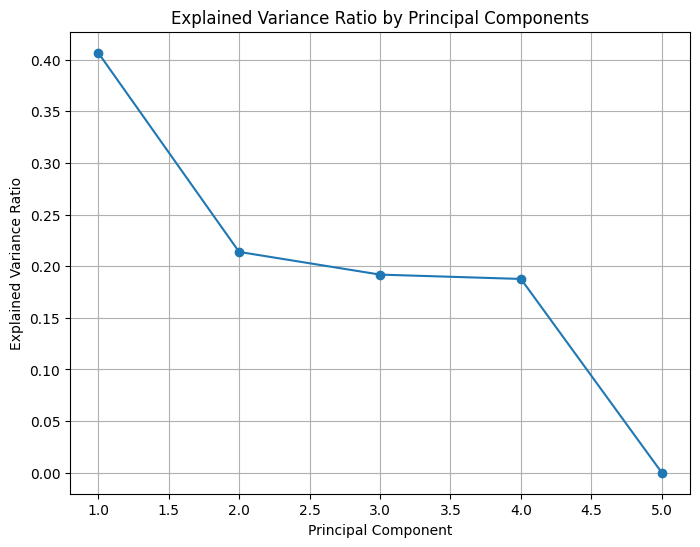

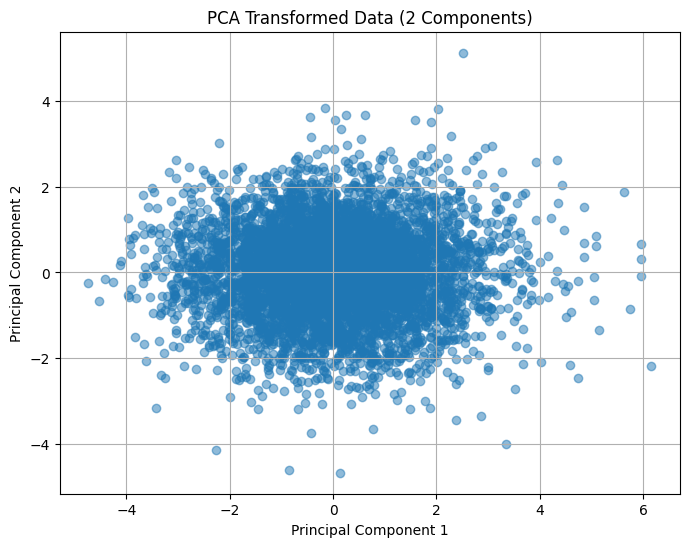

In [38]:
#extract 'strokes gained' stats for each golfer and scale them, apply PCA
numerical_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g']
data = df[numerical_features].values

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA()
pca.fit(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

#plotting pca, explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Reapply PCA with the chosen number of components
pca = PCA(n_components=n_components)
pca.fit(scaled_data)
transformed_data = pca.transform(scaled_data)

# Visualize the transformed data (if needed)
# For example, if n_components == 2
plt.figure(figsize=(8, 6))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
plt.title('PCA Transformed Data (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [24]:
# Calculates cosine similarity based on golfers' strokes gained
def find_similarities(golfer, df):
    golfer_row = df[df['player'] == golfer].index[0]
    golfer_features = df.iloc[golfer_row][numerical_features].values.reshape(1, -1)
    similarities = cosine_similarity(golfer_features, df[numerical_features])
    
    return similarities

In [25]:
#finds most similar golfers
def most_similar_golfers(similarity_scores, df, top_n=10):
    similar_golfers_indices = similarity_scores.argsort()[0][::-1][1:top_n+1]
    similar_golfers = df.iloc[similar_golfers_indices]
    
    return similar_golfers

In [57]:
# Define the number of clusters
num_clusters = 4  #adjustable

features_for_clustering = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g']

X = df_aggregated[features_for_clustering]

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(X)

df_aggregated['cluster'] = kmeans.labels_

#print the cluster centers
print("Cluster Centers:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=features_for_clustering))

#print the count of golfers in each cluster
print("\nCount of golfers in each cluster:")
print(df_aggregated['cluster'].value_counts())



Cluster Centers:
    sg_putt    sg_arg    sg_app    sg_ott    sg_t2g
0 -0.295890 -0.001247  0.288872  0.332192  0.377723
1  0.103194 -0.545169 -1.064300 -1.142964 -1.615917
2  0.027314 -0.451950 -0.385111  0.141295 -0.423675
3  0.098155  0.175929 -0.069006 -0.478361 -0.209239

Count of golfers in each cluster:
cluster
3    142
0    121
2     97
1     32
Name: count, dtype: int64


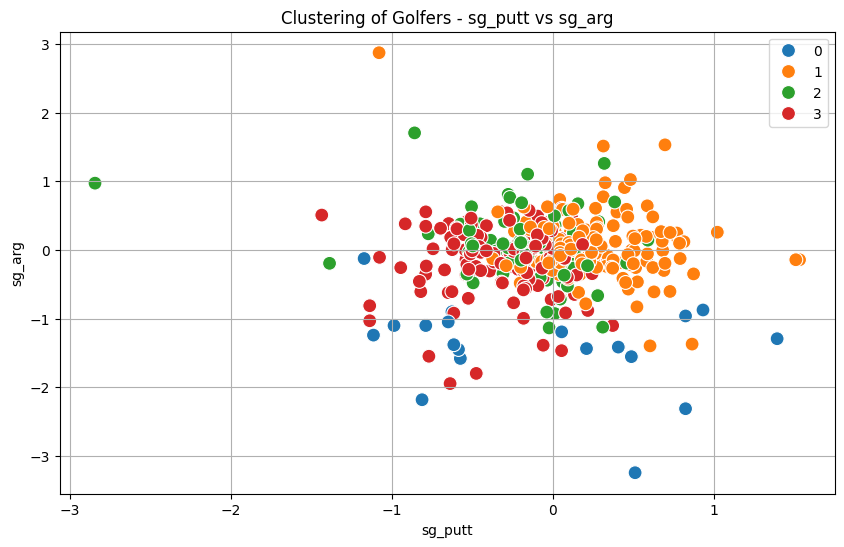

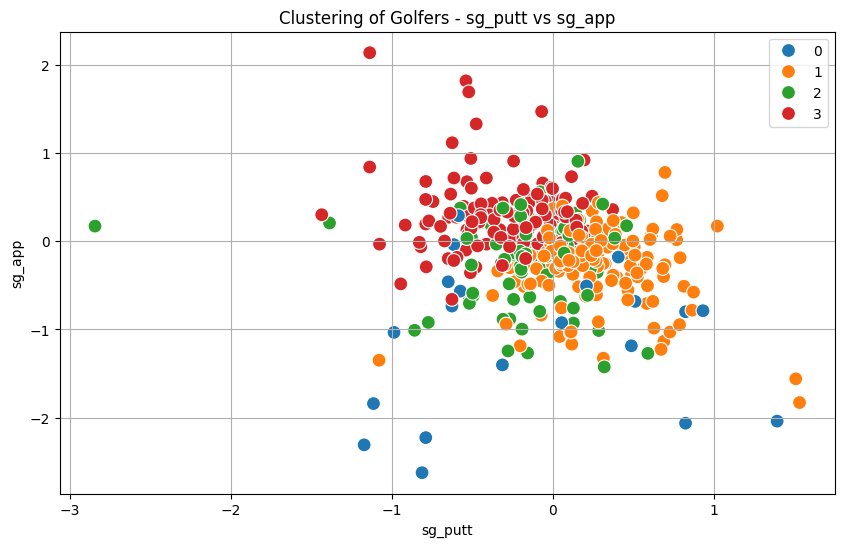

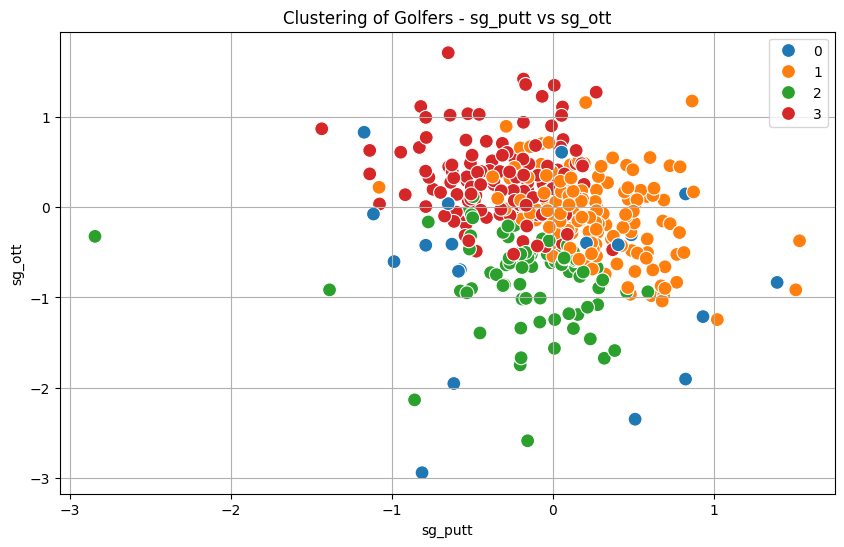

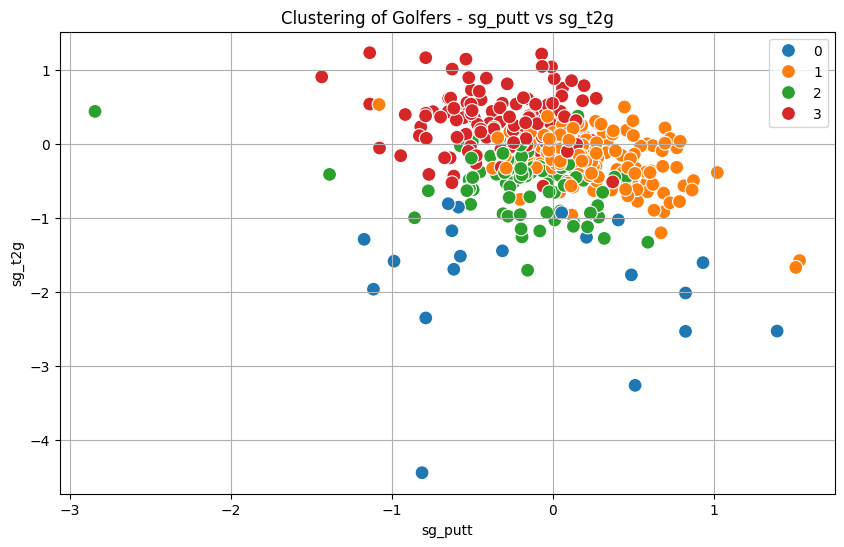

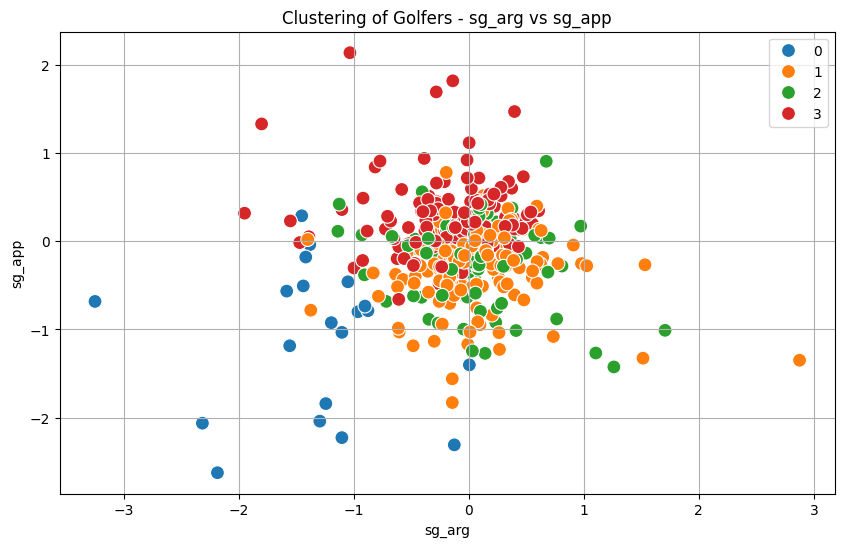

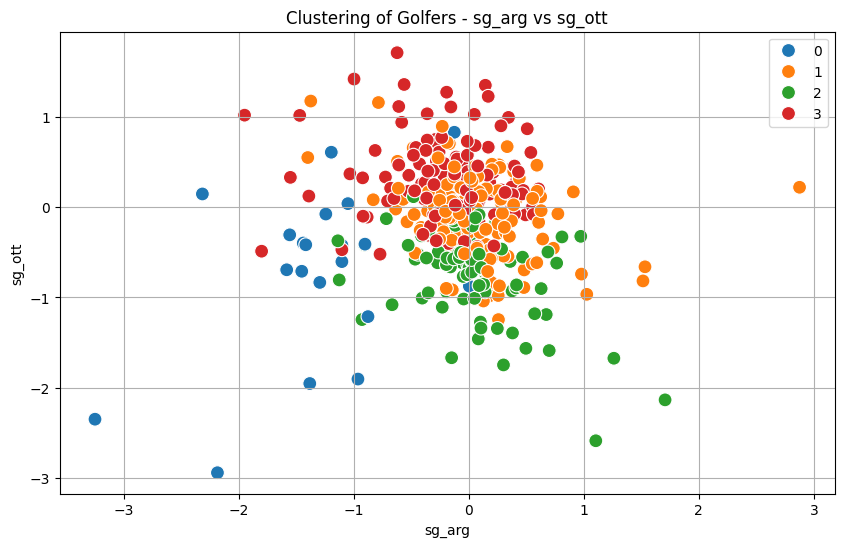

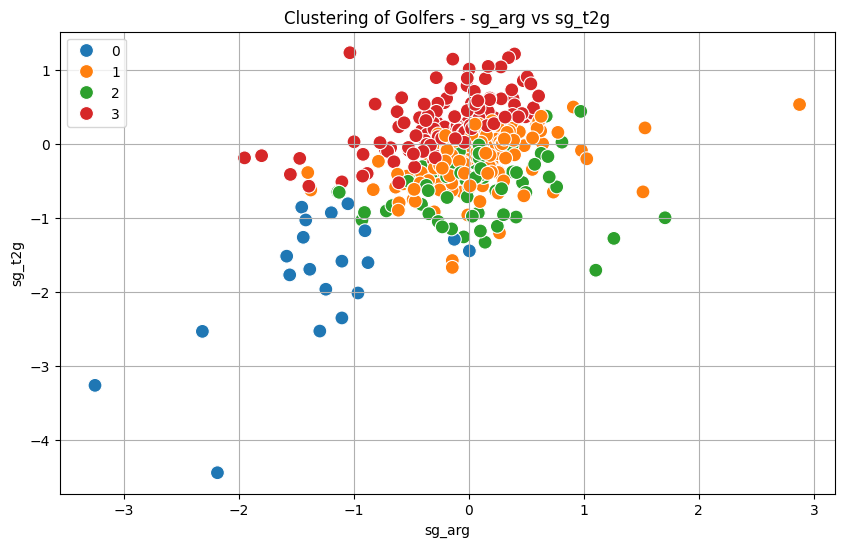

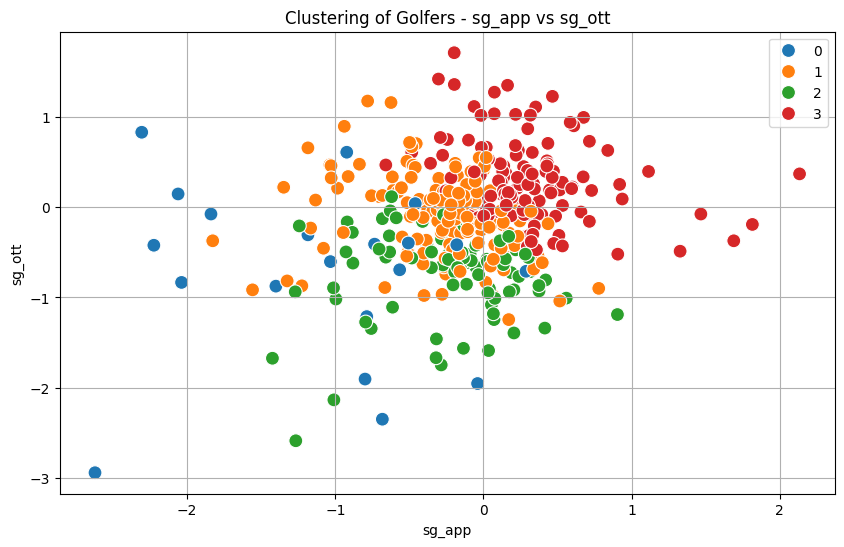

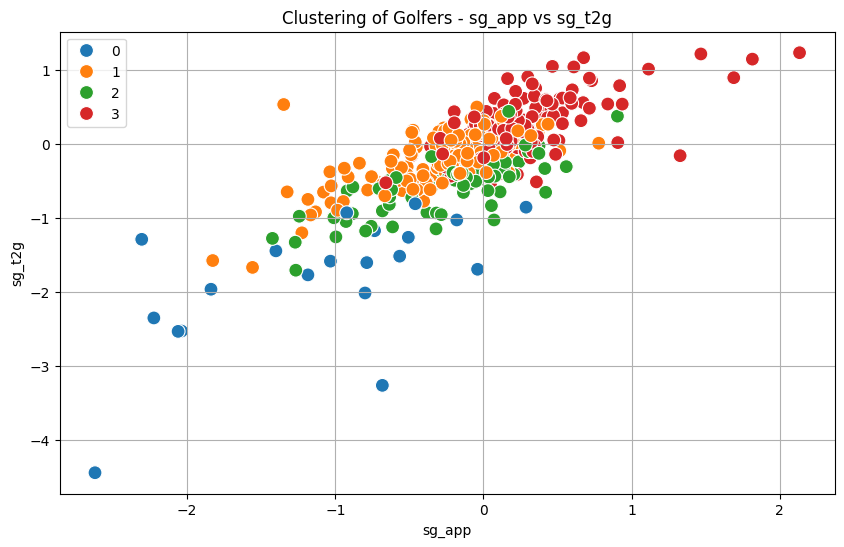

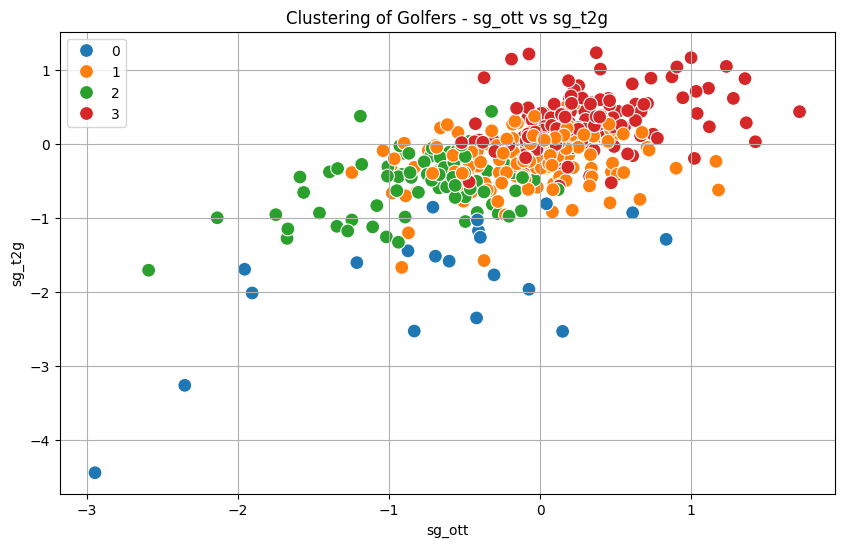

In [56]:
# Create pairwise combinations of features
feature_combinations = list(itertools.combinations(features_for_clustering, 2))

# Plotting each pair of features
for idx, (feat1, feat2) in enumerate(feature_combinations):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feat1, y=feat2, hue='cluster', data=df_aggregated, palette='tab10', s=100)
    plt.title(f'Clustering of Golfers - {feat1} vs {feat2}')
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.legend()
    plt.grid(True)
    plt.show()

In [62]:

# Define composite features representing player profiles
df_aggregated['Driving_Off_Tee_Strength'] = df_aggregated['sg_ott']
df_aggregated['Approach_Iron_Strength'] = df_aggregated['sg_app'] + df_aggregated['sg_t2g']
df_aggregated['Short_Game_Strength'] = df_aggregated['sg_arg'] + df_aggregated['sg_putt'] 

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_aggregated[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g',
                                                     'Driving_Off_Tee_Strength', 'Approach_Iron_Strength',
                                                     'Short_Game_Strength']])

# Apply K-means clustering
num_clusters = 4  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=43)
kmeans.fit(normalized_data)
df_aggregated['cluster'] = kmeans.labels_

# Interpret clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert cluster centers back to original scale


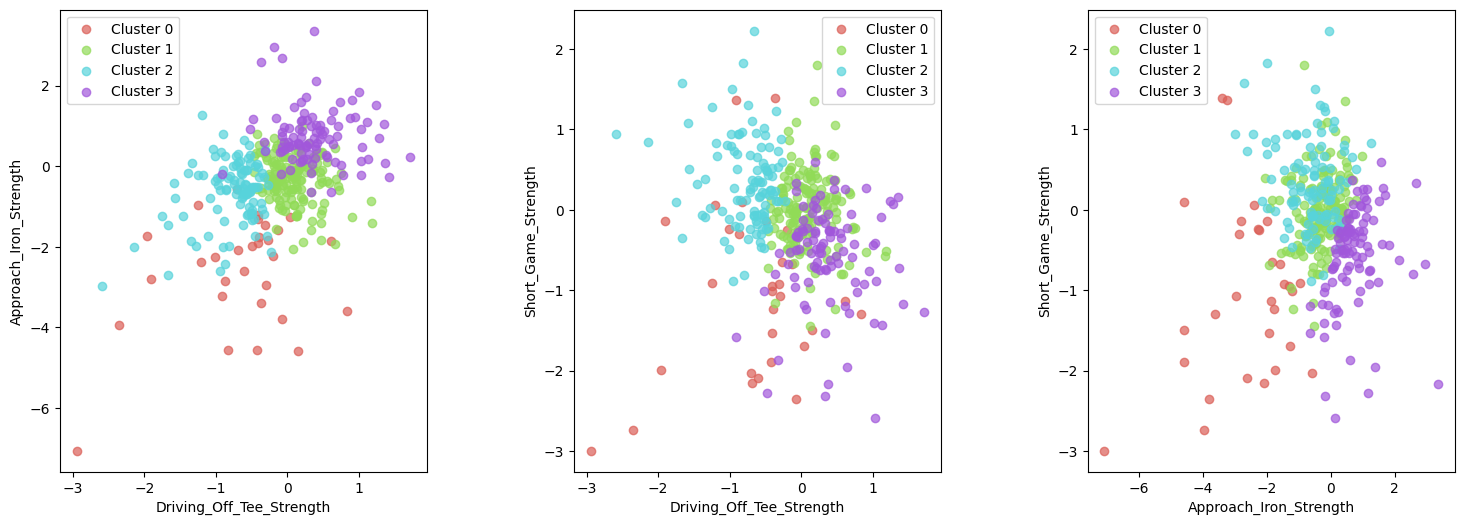

In [63]:
# Set up the grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Define feature pairs
feature_pairs = [('Driving_Off_Tee_Strength', 'Approach_Iron_Strength'),
                 ('Driving_Off_Tee_Strength', 'Short_Game_Strength'),
                 ('Approach_Iron_Strength', 'Short_Game_Strength')]

# Plot each pair of features
for i, (feature1, feature2) in enumerate(feature_pairs):
    ax = axes[i]

    # Plot each cluster
    for cluster_label, color in zip(range(num_clusters), sns.color_palette('hls', num_clusters)):
        cluster_data = df_aggregated[df_aggregated['cluster'] == cluster_label]
        ax.scatter(cluster_data[feature1], cluster_data[feature2], label=f'Cluster {cluster_label}', color=color, alpha=0.7)

    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.legend()

plt.show()


In [32]:
# Print the count of players in each cluster
print("Count of players in each cluster:")
print(df_aggregated['cluster'].value_counts())

# Print the list of players in each cluster
for cluster_label in range(num_clusters):
    print(f"\nPlayers in Cluster {cluster_label}:")
    players_in_cluster = df_aggregated[df_aggregated['cluster'] == cluster_label]['player']
    print(players_in_cluster)


Count of players in each cluster:
cluster
0    196
1    147
2     49
Name: count, dtype: int64

Players in Cluster 0:
0      Aaron Baddeley
1           Aaron Rai
4         Adam Hadwin
5           Adam Long
6         Adam Schenk
            ...      
382     Wyndham Clark
384      Xinjun Zhang
388         Zac Blair
389      Zach Johnson
391       Zecheng Dou
Name: player, Length: 196, dtype: object

Players in Cluster 1:
2             Aaron Wise
3          Abraham Ancer
7             Adam Scott
8          Adam Svensson
11            Alex Prugh
             ...        
380       Will Zalatoris
381       William McGirt
383    Xander Schauffele
385            Y.E. Yang
387           Yuta Ikeda
Name: player, Length: 147, dtype: object

Players in Cluster 2:
18             Andrew Loupe
24              Arjun Atwal
39             Brad Kennedy
40               Brad Marek
45            Brandon Stone
76        Chandler Phillips
86              Chris Baker
90           Chris Thompson
96           

In [71]:
# Function to find most similar players within each cluster and summarize the data
def summarize_similar_players(player_name, similarity_metric = 'cosine', top_n=3):
    player_data = df_aggregated[df_aggregated['player'] == player_name]
    cluster_label = player_data['cluster'].values[0]
    
    cluster_data = df_aggregated[df_aggregated['cluster'] == cluster_label]
    cluster_features = cluster_data[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g']]
    
    if similarity_metric == 'cosine':
        similarity_scores = cosine_similarity(player_data[features_for_clustering], cluster_features)
    
    similarities = similarity_scores[0]
    similar_players_indices = similarities.argsort()[-(top_n+1):-1][::-1]
    similar_players = cluster_data.iloc[similar_players_indices][['player', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']]
    
    return similar_players

player_name = 'Tiger Woods'

print(f"\nPlayer: {player_name}")
print(f"\nMost similar players for {player_name}:")
similar_players_data = summarize_similar_players(player_name)
print(similar_players_data.to_string(index=False))
    


Player: Tiger Woods

Most similar players for Tiger Woods:
            player   sg_putt    sg_arg   sg_app    sg_ott    sg_t2g  sg_total
Tyrone Van Aswegen -0.309010  0.090790 0.374735 -0.868038 -0.128941 -0.312788
       Davis Riley -0.573723  0.376488 0.375465 -0.927848 -0.027766 -0.028073
     Retief Goosen -0.154050 -0.080531 0.303390 -0.556158 -0.105287 -0.193643


In [ ]:
# Function to find most similar players within each cluster
def most_similar_players_in_cluster(cluster_label, similarity_metric='cosine', top_n=5):
    cluster_data = df_aggregated[df_aggregated['cluster'] == cluster_label]
    cluster_features = cluster_data[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']]
    
    # Compute similarity scores within the cluster
    if similarity_metric == 'cosine':
        similarity_scores = cosine_similarity(cluster_features, cluster_features)
    # You can add other similarity metrics here if needed
    
    # Find most similar players for each player in the cluster
    most_similar_players = {}
    for i, player_row in enumerate(cluster_data.itertuples()):
        player = player_row.player
        similarities = similarity_scores[i]
        similar_players_indices = similarities.argsort()[-(top_n+1):-1][::-1]  # Exclude the player itself
        similar_players = cluster_data.iloc[similar_players_indices]['player'].tolist()
        most_similar_players[player] = similar_players
    
    return most_similar_players

# Print most similar players in each cluster
for cluster_label in range(num_clusters):
    print(f"\nMost similar players in Cluster {cluster_label}:")
    similar_players = most_similar_players_in_cluster(cluster_label)
    for player, similar_players_list in similar_players.items():
        print(f"{player}: {similar_players_list}")
